In [6]:
# Library Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit 
from tqdm import tqdm
from numba import jit

from aRead import readAREPO, readSinks
import constants as c
matplotlib.rcParams.update({'figure.dpi': 150})

#### Sink Particle Mass Function

In [2]:
# Load in the sink data 
uv1s = readSinks(1, "/scratch/c.c1922522/bigClouds/UV1/sink_snap_148")
print(np.sum(uv1s.sinkMass))
uv10s = readSinks(1, "/scratch/c.c1922522/bigClouds/UV10/sink_snap_158")
print(np.sum(uv10s.sinkMass))
uv100s = readSinks(1, "/scratch/c.c1922522/bigClouds/UV100/sink_snap_166")
print(np.sum(uv100s.sinkMass))
uv1000s = readSinks(1, "/scratch/c.c1922522/bigClouds/UV1000/sink_snap_142")
print(np.sum(uv1000s.sinkMass))

2966.2716511632416
2968.961246767698
2765.186100618079
2984.1461087808466


In [2]:
# Load in the sink data 
uv1s = readSinks(1, "/scratch/c.c1922522/bigClouds/UV1/sink_snap_160")
print(np.sum(uv1s.sinkMass))
uv10s = readSinks(1, "/scratch/c.c1922522/bigClouds/UV10/sink_snap_160")
print(np.sum(uv10s.sinkMass))
uv100s = readSinks(1, "/scratch/c.c1922522/bigClouds/UV100/sink_snap_160")
print(np.sum(uv100s.sinkMass))
uv1000s = readSinks(1, "/scratch/c.c1922522/bigClouds/UV1000/sink_snap_160")
print(np.sum(uv1000s.sinkMass))

3743.9526811131805
3115.6779822710087
2374.9890851781547
3923.8958186547716


In [3]:
# Create the bins to plot against
#n, bins = np.histogram(np.log10(uv1000s.sinkMass), bins=20)
bins = np.linspace(np.min(np.log10(uv1s.sinkMass)), np.max(np.log10(uv1000s.sinkMass)), 25)

# Log all sink masses
m1 = np.log10(uv1s.sinkMass)
m2 = np.log10(uv10s.sinkMass)
m3 = np.log10(uv100s.sinkMass)
m4 = np.log10(uv1000s.sinkMass)

# Saltpeter fit function
def func(x, a, b):
    return b * (x**a)

# Get true masses and bins, not log
m1 = 10**m1
m2 = 10**m2
m3 = 10**m3
m4 = 10**m4
bins = 10**bins

In [4]:
# Fit a line of best-fit
def powerLawFit(x, alpha, beta):
    return x * alpha + beta

x = np.linspace(0, 2, 100)

def jeansMass(density, temperature, mu=2.4):
    return ((np.pi * c.kB() / c.G())**(3/2) * (temperature**3 / (mu**4 * c.mProt()**4 * density))**(1/2)) / 1.991e33

[-1.3010512   2.50853588] [0.07757262 0.08934832]
[-0.97614438  2.2515949 ] [0.05495073 0.06056474]
[-0.84425331  2.04773245] [0.0818903  0.09566205]
[-0.74929502  1.97752456] [0.04555509 0.05627798]


Text(0.08, 0.5, 'Number of Sinks')

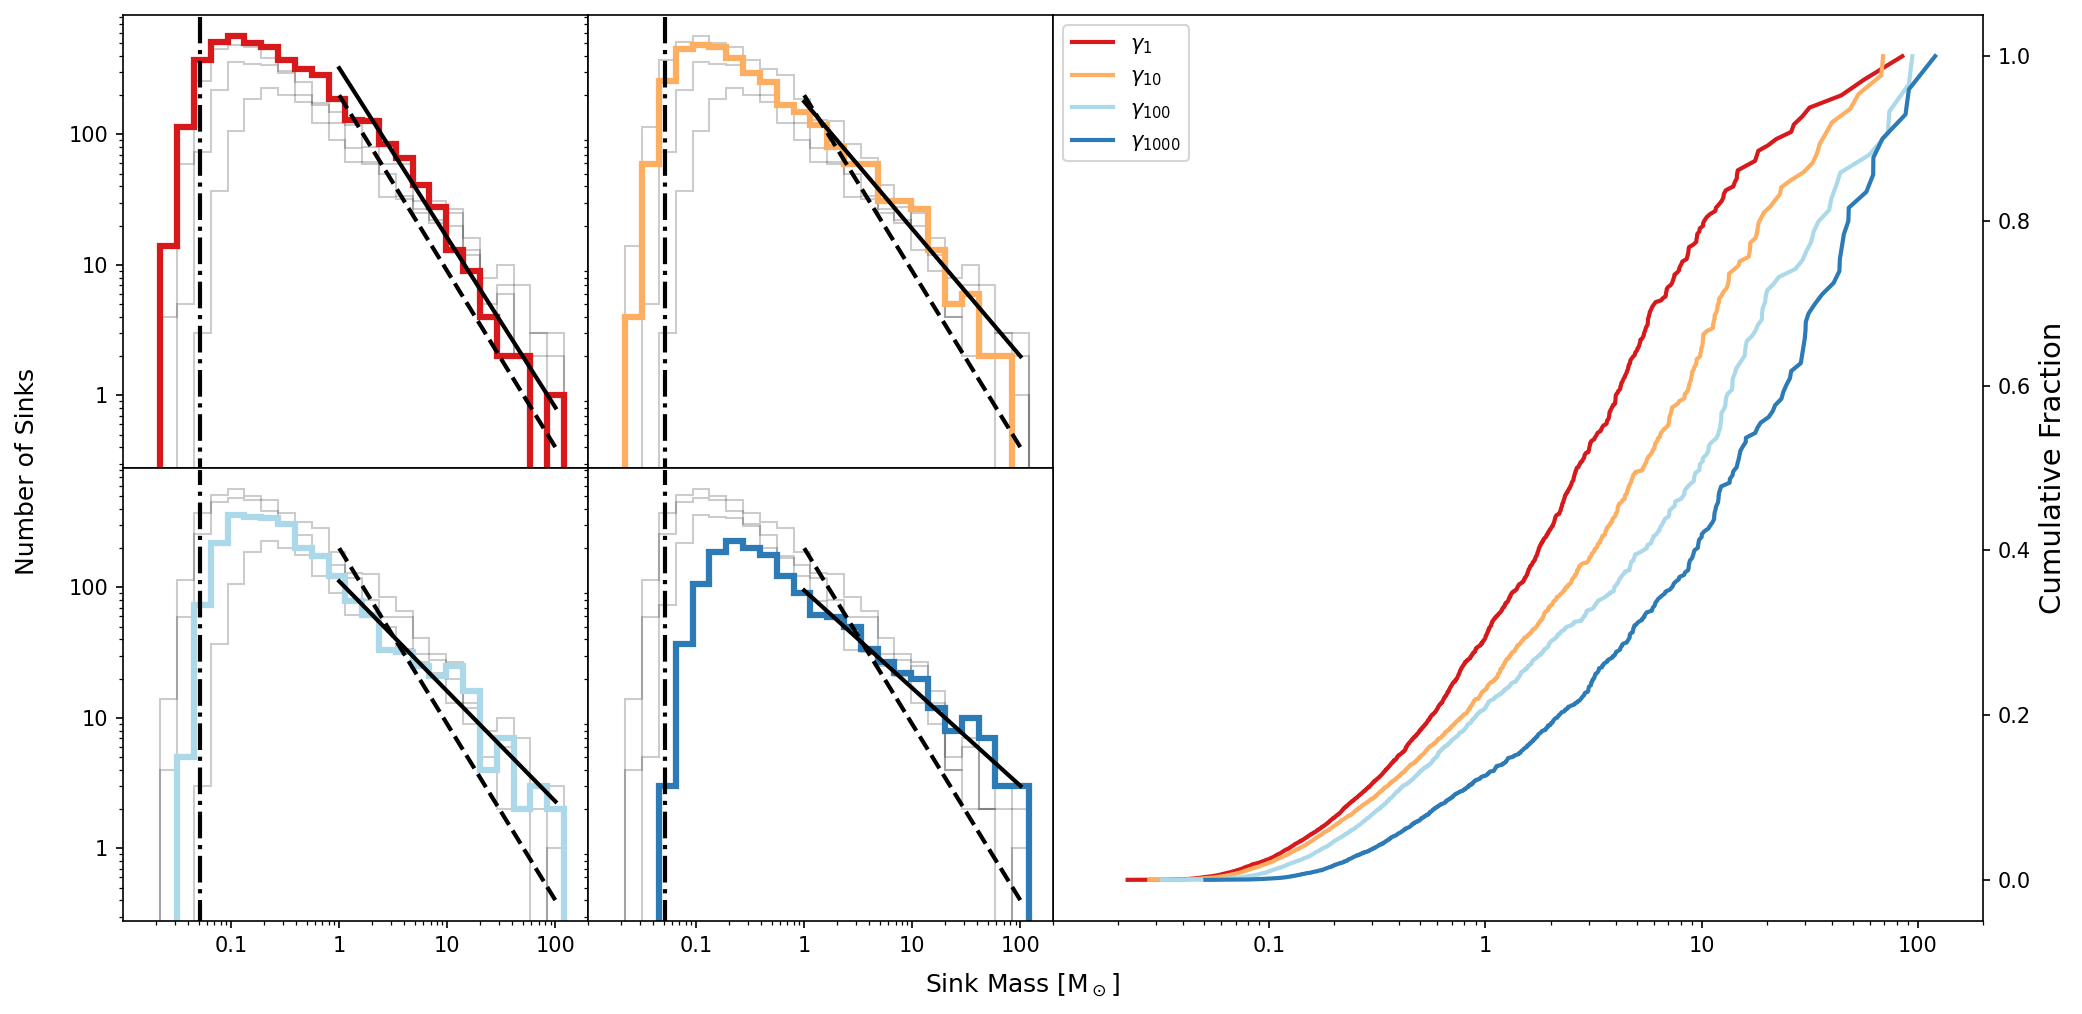

In [7]:
# Setup the figure and adjust
fig, axs = plt.subplot_mosaic([['upper left', 'upper center', 'right', 'right'],
                               ['lower left', 'lower center', 'right', 'right']],
                              figsize=(16, 8), sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)
matplotlib.rcParams.update({'figure.dpi': 150})

axes = ["upper left", "upper center", "lower left", "lower center"]
labels = ["$\\gamma_1$", "$\\gamma_{10}$", "$\\gamma_{100}$", "$\\gamma_{1000}$"]
colors = [c.colours()[0], c.colours()[1], c.colours()[3], c.colours()[4]]
m = [m1, m2, m3, m4]
x = np.linspace(0, 2, 100)

# Plot the IMFs
for i in range(4):
    thisPlot = m[i]
    notThisPlot = m[:i] + m[i+1:]

    hist = axs[axes[i]].hist(notThisPlot,  bins=bins, histtype="step", color=["k", "k", "k"], linestyle="-", alpha=0.2)
    hist = axs[axes[i]].hist(thisPlot, bins=bins, histtype="step", color=colors[i], linestyle="-", label="UV1", linewidth=3)
    axs[axes[i]].plot(10**x, 200*(10**x)**(-1.35), "k", linestyle="--", linewidth=2)

    axs[axes[i]].set_xscale("log")
    axs[axes[i]].set_yscale("log")

    axs[axes[i]].set_xticks([0.1, 1, 10, 100])
    axs[axes[i]].set_xticklabels(["0.1", "1", "10", "100"])

    if i == 1 or i == 3:
        axs[axes[i]].set_yticks([])
    else:
        axs[axes[i]].set_yticks([1, 10, 100])
        axs[axes[i]].set_yticklabels(["1", "10", "100"])

    axs[axes[i]].vlines(jeansMass(1e8, 10), 0, 800, "k", linestyle="-.", linewidth=2)

    # Fit and plot the best fit line
    hist = np.histogram(np.log10(thisPlot), bins=25)
    mass = hist[1][1:]
    nums = np.log10(hist[0])
    popt, pcov = curve_fit(powerLawFit, mass[mass>0], nums[mass>0])
    axs[axes[i]].plot(10**x, 10**(powerLawFit(x, *popt)), "k", linewidth=2)
    print(popt, np.sqrt(np.diag(pcov)))

    #axs[axes[i]].text(0.1,0.5, "N = %s" % len(thisPlot))

# Plot the cumulative distributions
for i in range(4):
    mSort = np.sort(m[i])
    mCum = np.cumsum(mSort)

    # Plot the data
    axs["right"].plot(mSort, mCum/mCum[-1], color=colors[i], linewidth=2, label=labels[i])
    
axs["right"].yaxis.tick_right()
axs["right"].set_ylabel("Cumulative Fraction", fontsize=14)
axs["right"].yaxis.set_label_position("right")
axs["right"].legend()
axs['right'].set_xlim(0.01, 200)

fig.supxlabel("Sink Mass $\\rm [M_\odot]$", y=0.06)
fig.supylabel("Number of Sinks", x=0.08)

#### Sink Formation History

In [2]:
# Load in the sink particle evolution files
uv1s = readSinks(4, "/scratch/c.c1922522/bigClouds/UV1/sink_particle_info/")
uv10s = readSinks(4, "/scratch/c.c1922522/bigClouds/UV10/sink_particle_info/")
uv100s = readSinks(4, "/scratch/c.c1922522/bigClouds/UV100/sink_particle_info/")
uv1000s = readSinks(4, "/scratch/c.c1922522/bigClouds/UV1000/sink_particle_info/")

In [17]:
import pandas as pd

# Sum the total mass in sinks at each dump
uv1s.totSinkMass = np.sum(uv1s.sinkMass, axis=1)
uv10s.totSinkMass = np.sum(uv10s.sinkMass, axis=1)
uv1000s.totSinkMass = np.sum(uv1000s.sinkMass, axis=1)
uv100s.totSinkMass = np.sum(uv100s.sinkMass, axis=1)

# We only want to go to the end of the free fall time
uv1s.totSinkMass = uv1s.totSinkMass[uv1s.time <= 16]
uv10s.totSinkMass = uv10s.totSinkMass[uv10s.time <= 16]
uv100s.totSinkMass = uv100s.totSinkMass[uv100s.time <= 16]
uv1000s.totSinkMass = uv1000s.totSinkMass[uv1000s.time <= 16]

uv1s.time = uv1s.time[uv1s.time <= 16]
uv10s.time = uv10s.time[uv10s.time <= 16]
uv100s.time = uv100s.time[uv100s.time <= 16]
uv1000s.time = uv1000s.time[uv1000s.time <= 16]

# Convert code unit time into real time for real SFR
uv1s.snapTimeReal = uv1s.time/(c.uTime() * c.year())
uv10s.snapTimeReal = uv10s.time/(c.uTime() * c.year())
uv100s.snapTimeReal = uv100s.time/(c.uTime() * c.year()) 
uv1000s.snapTimeReal = uv1000s.time/(c.uTime() * c.year())

# Calculate the deriviates
uv1s.sfr = (uv1s.totSinkMass[2::] - uv1s.totSinkMass[0:-2]) / (2 * uv1s.snapTimeReal[2::] - uv1s.snapTimeReal[0:-2])
uv10s.sfr = (uv10s.totSinkMass[2::] - uv10s.totSinkMass[0:-2]) / (2 * uv10s.snapTimeReal[2::] - uv10s.snapTimeReal[0:-2])
uv100s.sfr = (uv100s.totSinkMass[2::] - uv100s.totSinkMass[0:-2]) / (2 * uv100s.snapTimeReal[2::] - uv100s.snapTimeReal[0:-2])
uv1000s.sfr = (uv1000s.totSinkMass[2::] - uv1000s.totSinkMass[0:-2]) / (2 * uv1000s.snapTimeReal[2::] - uv1000s.snapTimeReal[0:-2])

def calcRolling(data, window):
    df = pd.DataFrame({"t": data.snapTimeReal[1:-1], "s": data.sfr})
    return df["s"].rolling(window).mean()

In [5]:
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.dpi': 150})

# Setup figure
plt.figure(figsize=(8,6))

# Find rolling mean of the sink formation rates
window=500
sfr1 = calcRolling(uv1s, window)
sfr10 = calcRolling(uv10s, window)
sfr100 = calcRolling(uv100s, window)
sfr1000 = calcRolling(uv1000s, window)

# Plot the data
plt.plot(uv1s.snapTimeReal[1:-1], sfr1, color=c.colours()[0], label="$\\gamma_1$", linewidth=2)
plt.plot(uv10s.snapTimeReal[1:-1], sfr10, color=c.colours()[1], label="$\\gamma_{10}$", linewidth=2)
plt.plot(uv100s.snapTimeReal[1:-1], sfr100, color=c.colours()[3], label="$\\gamma_{100}$", linewidth=2)
plt.plot(uv1000s.snapTimeReal[1:-1], sfr1000, color=c.colours()[4], label="$\\gamma_{1000}$", linewidth=2)

# Format the figure
plt.xlabel("Time [kyr]")
plt.ylabel("Sink Formation Rate  [$\\rm M_\odot yr^{-1}$]")
plt.legend()
plt.yscale("log")
plt.xticks([4e5, 6e5, 8e5, 10e5, 12e5, 14e5], [400, 600, 800, 1000, 1200, 1400])

NameError: name 'calcRolling' is not defined

<Figure size 1200x900 with 0 Axes>

#### Nearest Neighbor At Formation

In [3]:
# Working out the distance to the nearest neighbour at each sinks formation time
def nearestSinkAtFormation(sinkData):
    # Get all of the unique sink IDs
    maxSinks = np.where(sinkData.nSinks == np.max(sinkData.nSinks))
    maxSinks = maxSinks[0]
    if len(maxSinks) != 1:
        maxSinks = maxSinks[-1]

    formationTimes = sinkData.formationTime[maxSinks]
    formationTimes = formationTimes[formationTimes != 0]

    uniqueIDs = sinkData.sinkID[maxSinks]
    if len(uniqueIDs) == 1:
        uniqueIDs = uniqueIDs[0]
    uniqueIDs = uniqueIDs[np.argsort(formationTimes)]

    formationTimes = np.sort(formationTimes)

    # Create storage arrays
    nearest = np.zeros_like(formationTimes)
    fifthNearest = np.zeros_like(formationTimes)
    tenthNearest = np.zeros_like(formationTimes)
    twentiethNearest = np.zeros_like(formationTimes)
    nearestID = np.zeros_like(formationTimes)

    # Loop through all the sinks
    for i in tqdm(range(1,len(formationTimes)-1)):
        # Get the index where this sink formed
        timeIndex = np.where(sinkData.time == formationTimes[i])

        # Get the sink data at this time
        sinkX = sinkData.sinkX[timeIndex]
        sinkY = sinkData.sinkY[timeIndex]
        sinkZ = sinkData.sinkZ[timeIndex]

        # Find the sink we're looking at
        sinkIndex = np.where(sinkData.formationOrder[timeIndex] == i+1)
        myX = sinkX[sinkIndex]
        myY = sinkY[sinkIndex]
        myZ = sinkZ[sinkIndex]

        if len(timeIndex[0]) == 0:
            pass
        else:
            # Get all the ids of the sinks
            ids = sinkData.sinkID[timeIndex][0]

            # Find every sink's distance to this
            r = np.sqrt((sinkX - myX)**2 + (sinkY - myY)**2 + (sinkZ - myZ)**2)

            # Get rid of distance to myself
            r = r[r != 0]
            rSorted = np.sort(r)

            # Assign nearest distances
            nearest[i] = rSorted[0]
            idNearest = np.where(r == nearest[i])
            nearestID[i] = ids[idNearest[0]]

            if len(r) < 5:
                fifthNearest[i] = 0
            else:
                fifthNearest[i] = rSorted[4]
                if len(r) < 10:
                    tenthNearest[i] = 0
                else:
                    tenthNearest[i] = rSorted[9]
                    if len(r) < 20:
                        twentiethNearest[i] = 0
                    else:
                        twentiethNearest[i] = rSorted[19]

    return formationTimes, nearest, fifthNearest, tenthNearest, twentiethNearest

In [4]:
# Find nearest neighbours for each cloud
_, a1, a5, a10, a20 = nearestSinkAtFormation(uv1s)
_, b1, b5, b10, b20 = nearestSinkAtFormation(uv10s)
_, c1, c5, c10, c20 = nearestSinkAtFormation(uv100s)
_, d1, d5, d10, d20 = nearestSinkAtFormation(uv1000s)

  0%|          | 0/5814 [00:00<?, ?it/s]

/tmp/ipykernel_17288/1115938185.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nearestID[i] = ids[idNearest[0]]
100%|██████████| 2072/2072 [00:00<00:00, 8574.94it/s]


([<matplotlib.axis.XTick at 0x2b306b1ab820>,
 [Text(1, 0, '1'), Text(2, 0, '10'), Text(3, 0, '100'), Text(4, 0, '1000')])

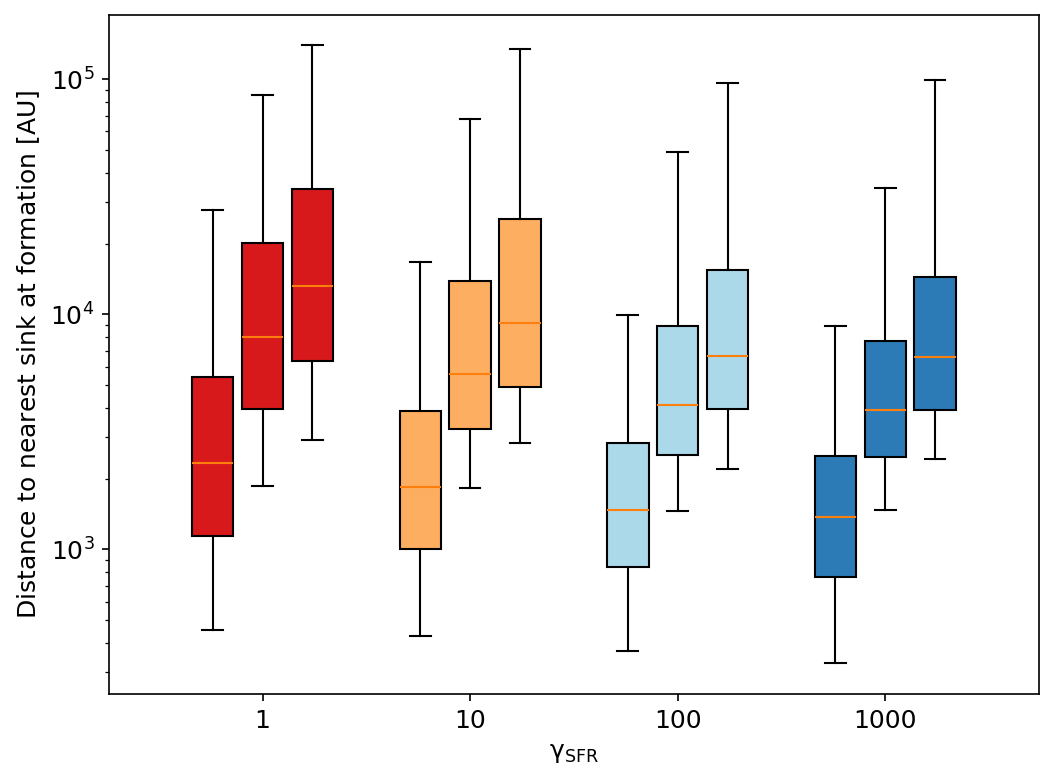

In [11]:
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.dpi': 150})

e = 1e17 / 1.5e13

near1 = [e*a1, e*b1, e*c1, e*d1] 
near5 = [e*a5, e*b5, e*c5, e*d5]
near10 = [e*a10, e*b10, e*c10, e*d10]

# Set the properties of the box plots
boxWidths = 0.2
posBase = np.linspace(1, 4, 4)

# Create the box plots
n1b = plt.boxplot(near1, widths=boxWidths, positions=posBase-1.2*boxWidths, patch_artist=True, tick_labels=["UV1", "UV10", "UV100", "UV1000"], whis=[5,95], showfliers=False)
n5b = plt.boxplot(near5, widths=boxWidths, positions=posBase, patch_artist=True, tick_labels=["UV1", "UV10", "UV100", "UV1000"], whis=[5,95], showfliers=False)
n10b = plt.boxplot(near10, widths=boxWidths, positions=posBase+1.2*boxWidths, patch_artist=True, tick_labels=["UV1", "UV10", "UV100", "UV1000"], whis=[5,95], showfliers=False)

# Colour the box plots
boxColors = [c.colours()[0], c.colours()[1], c.colours()[3], c.colours()[4]]
for bplot in a1:
    for patch, color in zip(n1b['boxes'], boxColors):
        patch.set_facecolor(color)
    for patch, color in zip(n5b['boxes'], boxColors):
        patch.set_facecolor(color)
    for patch, color in zip(n10b['boxes'], boxColors):
        patch.set_facecolor(color)

plt.ylabel("Distance to nearest sink at formation [$\\rm AU$]")
plt.yscale("log")
plt.xlabel("$\\rm \gamma_{SFR}$")
plt.xticks([1, 2, 3, 4], [1, 10, 100, 1000])

#### Sink Mass Function Evolution

Text(0.04, 0.5, 'Frequency Density')

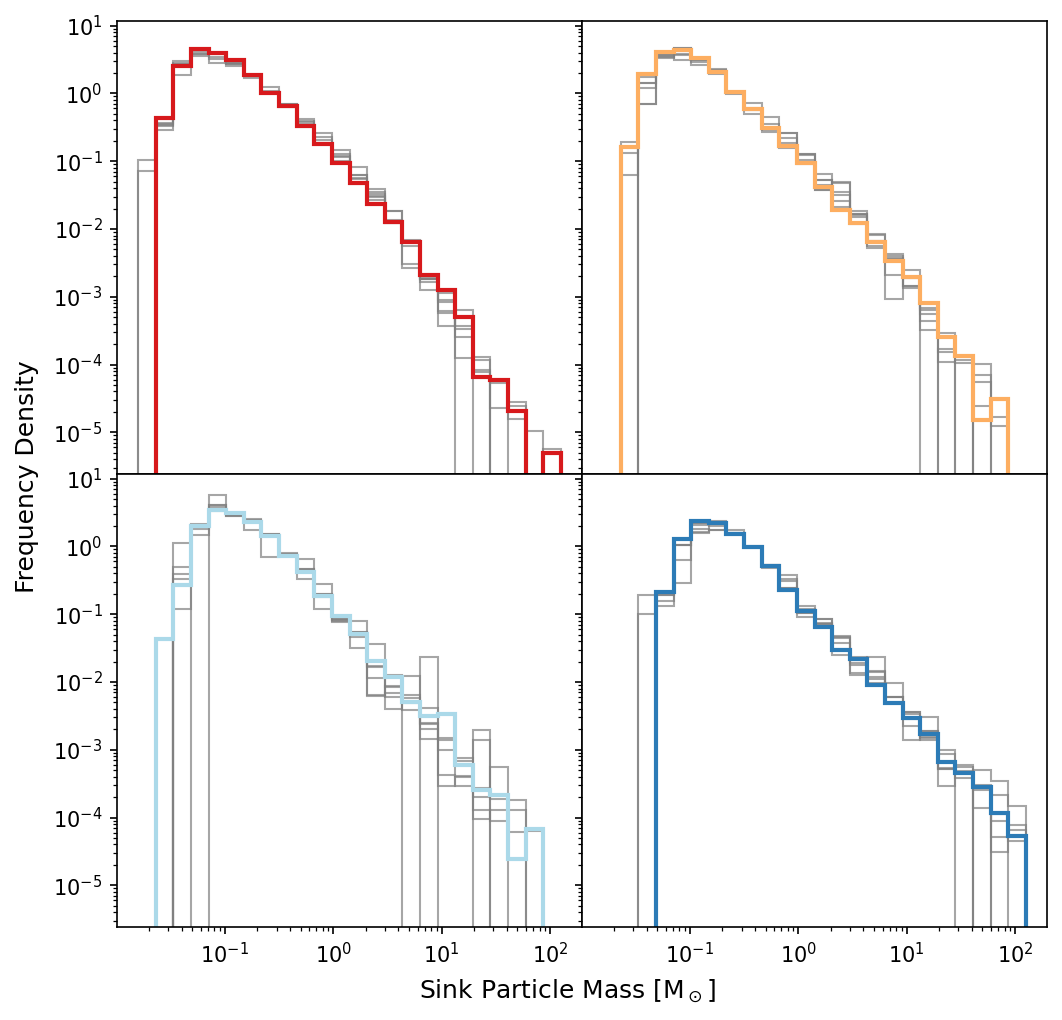

In [25]:
# Numbers of the snapshots we want to load and mass bins
snapNums = [100, 110, 120, 130, 140, 150, 160]
bins = 10**np.linspace(-1.8, 2.1, 25)

# Setup figure
fig, ax = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

paths = np.array([[1, 10], [100, 1000]])
colours = np.array([[c.colours()[0], c.colours()[1]],[c.colours()[3], c.colours()[4]]])

for i in range(2):
    for j in range(2):
        axes = ax[i,j]

        # Loop through each snapshot and load it in
        for k in range(len(snapNums)):
            data = readSinks(1, "/scratch/c.c1922522/bigClouds/UV" + str(paths[i,j]) + "/sink_snap_" + str(snapNums[k]))

            if k < len(snapNums)-1:
                axes.hist(data.sinkMass, bins=bins, histtype="step", density=True, color="gray", alpha=0.7)
            else:
                axes.hist(data.sinkMass, bins=bins, histtype="step", density=True, color=colours[i,j], linewidth=2)

        axes.set_xscale("log")
        axes.set_yscale("log")

fig.supxlabel("Sink Particle Mass $\\rm [M_\\odot]$", y=0.06)
fig.supylabel("Frequency Density", x=0.04)

#### Accretion Rates

In [72]:
@jit(nopython=True)
def findAccretionRate(sinks, ids, masses, times):
    # Work out shape of the data
    dataShape = np.shape(masses)
    numSinks = np.shape(sinks)
    mAtAccrete = []
    accreteRat = []

    for i in range(numSinks[0]):
        m = []
        t = []

        # Get properties of this sinks
        for j in range(dataShape[0]):
            for k in range(dataShape[1]):
                if ids[j,k] == sinks[i]:
                    m.append(masses[j,k])
                    t.append(times[j]*np.float64(87019)) 

        mLen = np.shape(m)

        for j in range(mLen[0]):
            for k in range(j, mLen[0]):
                if m[k] > 1.1*m[j]:
                    mAbove = m[k]
                    tAbove = t[k]

                    dm = mAbove - m[j]
                    dt = tAbove - t[j]

                    mAtAccrete.append(m[j])
                    accreteRat.append(dm/dt)
                    
                    break

    mAtAccrete = np.array(mAtAccrete)
    accreteRat = np.array(accreteRat)

    return mAtAccrete, accreteRat

def getAccretionAboveMass(data, mass):
    # Get IDs of sinks that end with a particular mass
    highMassSinks = np.where(data.sinkMass[-1] > mass)
    highMassSinkIDs = data.sinkID[-1][highMassSinks]

    m, a = findAccretionRate(highMassSinkIDs, data.sinkID, data.sinkMass, data.time)

    return m, a

In [56]:
def line(x, a):
    return x * a

In [77]:
m1, a1 = getAccretionAboveMass(uv1s, 1)
m10, a10 = getAccretionAboveMass(uv10s, 1)
m100, a100 = getAccretionAboveMass(uv100s, 1)
m1000, a1000 = getAccretionAboveMass(uv1000s, 1)

Text(0.045, 0.5, 'Accretion Rate $\\rm [M_\\odot \\, yr^{-1}]$')

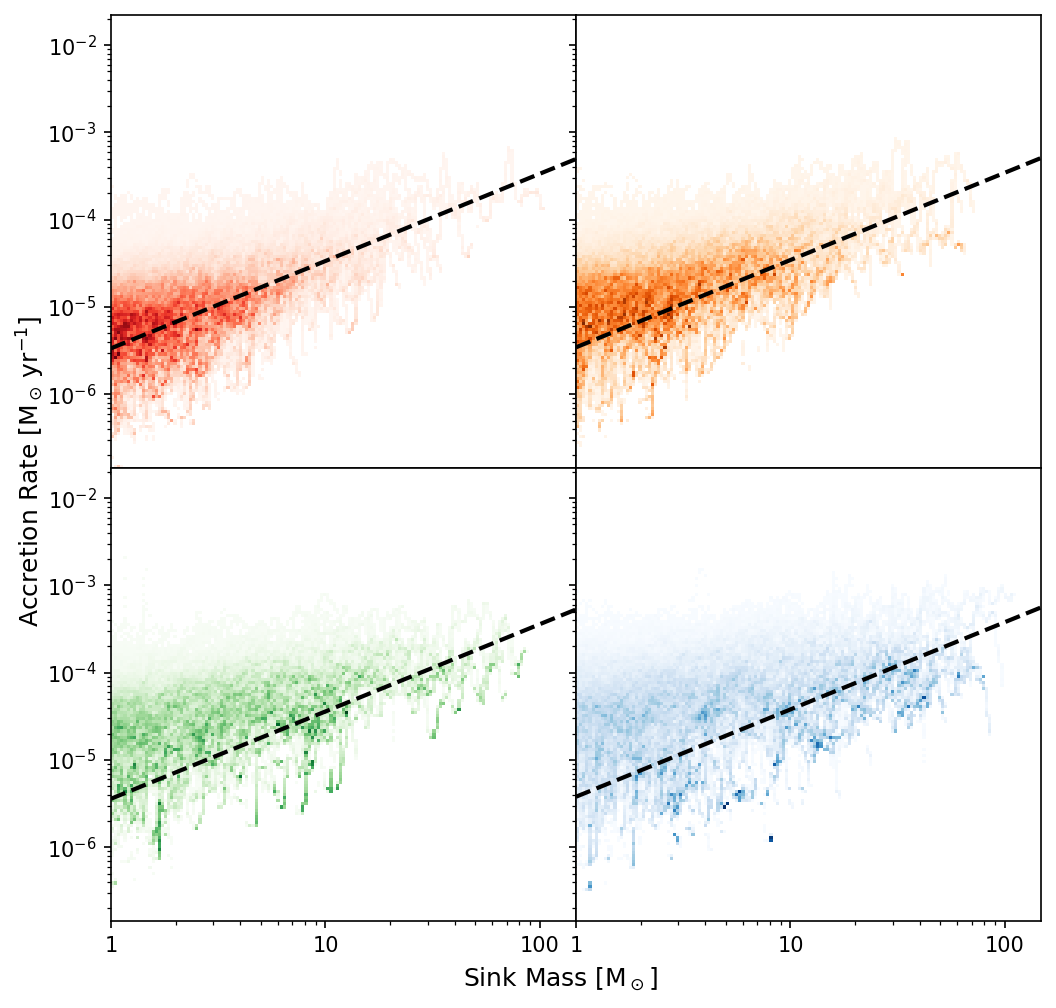

In [85]:
fig, axs = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Create xy bins
xBins = 10**np.linspace(0, np.log10(1.35*np.max(m1000)), 150)
yBins = 10**np.linspace(np.log10(np.min(a1)), np.log10(np.max(a1000)), 150)

mS = np.array([[m1, m10], [m100, m1000]], dtype=object)
aS = np.array([[a1, a10], [a100, a1000]], dtype=object)
cm = np.array([["Reds", "Oranges"], ["Greens", "Blues"]])

for i in range(2):
    for j in range(2):
        ax = axs[i,j]

        h = ax.hist2d(mS[i,j], aS[i,j], bins=(xBins, yBins), cmap=cm[i,j], cmin=0.001)
        popt, pcov = curve_fit(line, mS[i,j], aS[i,j])
        ax.plot(xBins, xBins*popt[0], "k--", linewidth=2)

axs[0,0].set_xscale("log")
axs[0,0].set_yscale("log")

axs[0,0].set_xticks([1, 10, 100])
axs[0,0].set_xticklabels([1, 10, 100])

fig.supxlabel("Sink Mass $\\rm [M_\\odot]$", y=0.065)
fig.supylabel("Accretion Rate $\\rm [M_\\odot \\, yr^{-1}]$", x=0.045)

Text(0, 0.5, 'Accretion Rate $\\rm [M_\\odot \\, yr^{-1}]$')

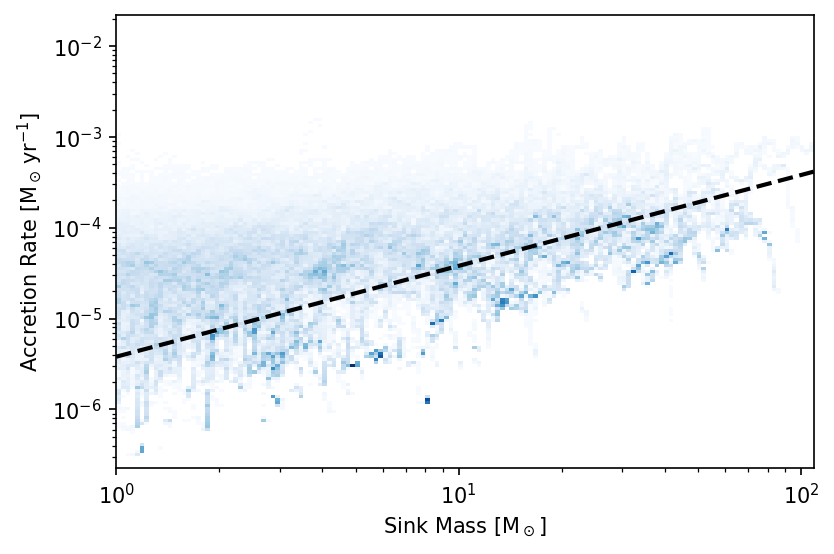

In [71]:
# Create xy bins
xBins = 10**np.linspace(0, np.log10(np.max(m)), 150)
yBins = 10**np.linspace(np.log10(np.min(a)), np.log10(np.max(a)), 150)

# Fit a line
popt, pcov = curve_fit(line, m, a)

# Plot the histogram
h = plt.hist2d(m, a, bins=(xBins, yBins), cmin=0.001, cmap="Blues")
plt.plot(xBins, xBins*popt[0], "k--", linewidth=2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Sink Mass $\\rm [M_\\odot]$")
plt.ylabel("Accretion Rate $\\rm [M_\\odot \\, yr^{-1}]$")


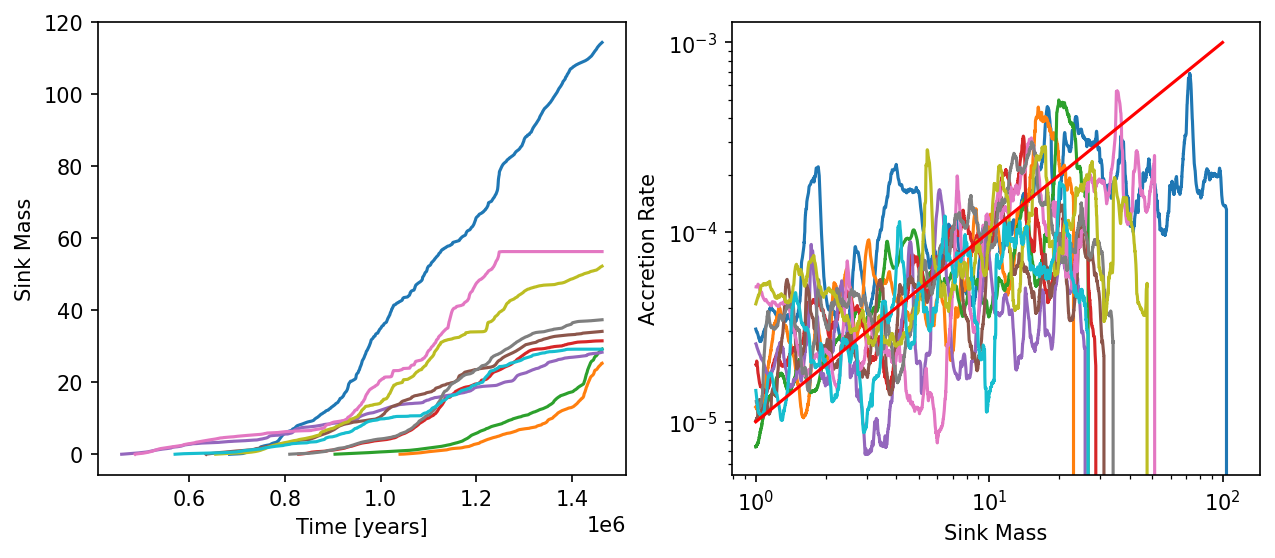

In [11]:
# Get IDs of sinks that end with a particular mass
highMassSinks = np.where(uv1s.sinkMass[-1] > 25)
highMassSinkIDs = uv1s.sinkID[-1][highMassSinks]

fig, axs = plt.subplots(1,2, figsize=(10, 4))

axs[0].set_xlabel("Time [years]")
axs[0].set_ylabel("Sink Mass")

for j in range(len(highMassSinkIDs)):
    # Get the data for this sink
    thisSink = np.where(uv1s.sinkID == highMassSinkIDs[j])
    mass = uv1s.sinkMass[thisSink]
    time = uv1s.time[thisSink[0]] / c.uTime() / c.year()

    # Create array for mdot
    mdot = np.zeros_like(mass)

    # Find 10% accretion rate
    for i in range(len(mass)):
        massAbove = mass[mass>mass[i]*1.1]
        timeAbove = time[mass>mass[i]*1.1]

        if len(massAbove) == 0:
            break
        else:
            dm = massAbove[0] - mass[i]
            dt = timeAbove[0] - time[i]

            mdot[i] = dm/dt

    axs[0].plot(time, mass)
    axs[1].plot(mass[mass>1], mdot[mass>1], label="10 % Increase")

x = 10**np.linspace(0, 2, 100)
axs[1].plot(x, 1e-5*x, "r")

axs[1].set_xlabel("Sink Mass")
axs[1].set_ylabel("Accretion Rate")
axs[1].set_yscale("log")
axs[1].set_xscale("log")

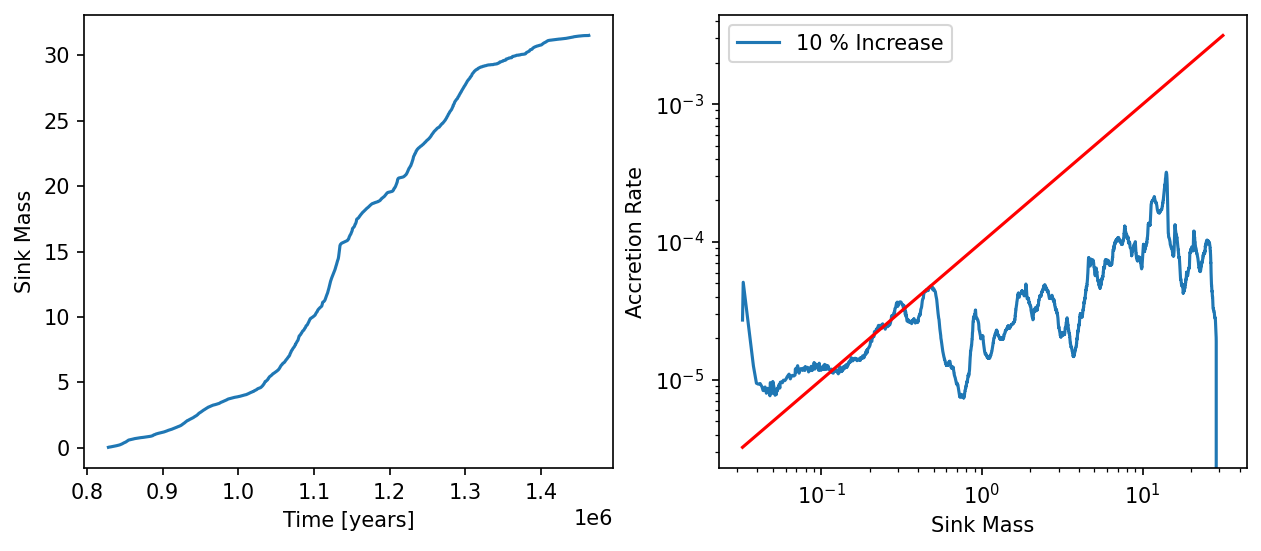

In [62]:
# Work out the accretion rate for one sink

# Find the datapoints corresponding to this sink
sinkID = highMassSinkIDs[3]
thisSink = np.where(uv1s.sinkID == sinkID)

# Get the data for this sink
mass = uv1s.sinkMass[thisSink]
time = uv1s.time[thisSink[0]] / c.uTime() / c.year()

fig, axs = plt.subplots(1,2, figsize=(10, 4))

axs[0].plot(time, mass)
axs[0].set_xlabel("Time [years]")
axs[0].set_ylabel("Sink Mass")

# Create array for mdot
mdot = np.zeros_like(mass)

# Find 10% accretion rate
for i in range(len(mass)):
    massAbove = mass[mass>mass[i]*1.1]
    timeAbove = time[mass>mass[i]*1.1]

    if len(massAbove) == 0:
        break
    else:
        dm = massAbove[0] - mass[i]
        dt = timeAbove[0] - time[i]

        mdot[i] = dm/dt


axs[1].plot(mass, mass*1e-4, "r")

axs[1].set_xlabel("Sink Mass")
axs[1].set_ylabel("Accretion Rate")
axs[1].set_yscale("log")
axs[1].set_xscale("log")
axs[1].legend()

In [8]:
# Calculate the time it takes to accrete 10% of a sinks mass, as well as the instantaneous accretion rate 
def timeToAccreteSingular(formationMass, sinkMass, time, sinkID, id):
    # Selecting our masses and times 
    indicies = np.where(sinkID == id)
    masses = sinkMass[indicies]
    times = time[indicies[0]] / (c.uTime() * c.year())

    # Working out 10% of each mass
    frac = masses * 0.1

    # Array to store the time
    timeToAccrete = np.zeros_like(frac)
    instAccretion = np.zeros_like(frac)
    massAtAccrete = np.zeros_like(frac)

    # Looping through each
    for i in range(len(frac)):
        # Getting the range where we've grown by 10%
        m = masses[masses > masses[i]*1.1]
        t = times[masses > masses[i]*1.1]

        # Passing the zero values
        if len(m) == 0:
            pass
        else:
            # Selecting the first time its over 10%
            t = t[0] - times[i]

            # Storing the time
            timeToAccrete[i] = t

            # Storing the instantaneous accretion rate
            instAccretion[i] = (m[0] - masses[i])/t

            # Storing the mass at this time
            massAtAccrete[i] = m[0]

    # Ignoring null values
    timeToAccrete = timeToAccrete[timeToAccrete > 0]
    instAccretion = instAccretion[instAccretion > 0]
    massAtAccrete = massAtAccrete[massAtAccrete > 0]

    return timeToAccrete, instAccretion, massAtAccrete

In [41]:
from scipy.optimize import curve_fit

def lineFit(x, a, b):
    return a * x ** b

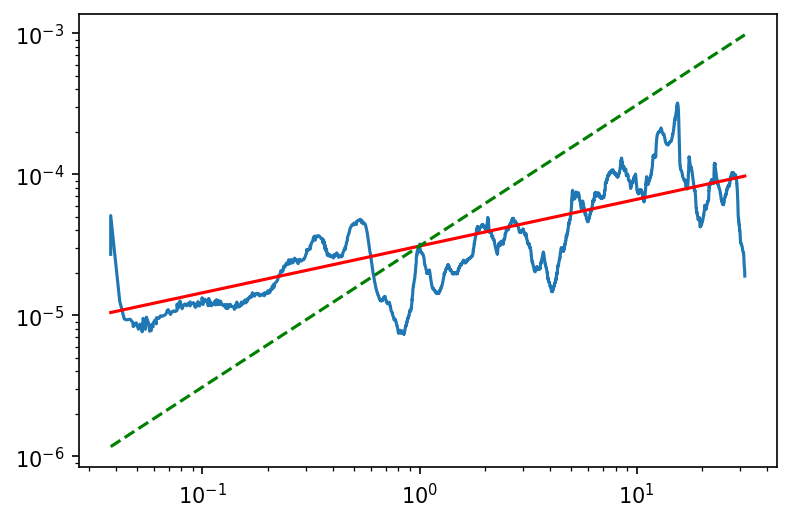

In [61]:
# Select a sink
allIDs = uv1s.sinkID[-1]
id = allIDs[np.where(uv1s.sinkMass[-1] == np.sort(uv1s.sinkMass[-1])[-6])]
t, a, m = timeToAccreteSingular(uv1s.formationMass, uv1s.sinkMass, uv1s.time, uv1s.sinkID, id)

popt, pcov = curve_fit(lineFit, m, a)

matplotlib.rcParams.update({'figure.dpi': 150})
plt.figure(figsize=(6,4))

plt.plot(m, a)
plt.yscale("log")
plt.xscale("log")

x = np.linspace(np.min(m), np.max(m), 100)
plt.plot(x, (x**popt[1])*popt[0], "r")
plt.plot(x, x * popt[0], "g--")



### New VS Old Run Comparison

In [2]:
dNew = readSinks(1, "/scratch/c.c1922522/bigClouds/UV1000r2/sink_snap_055")
dOld = readSinks(1, "/scratch/c.c1922522/bigClouds/UV1000/sink_snap_110")

In [9]:
print(dNew.nSinks, dOld.nSinks, np.sum(dNew.sinkMass/1.991e33), np.sum(dOld.sinkMass/1.991e33))

39 56 5.568519870923336 19.400340940841794


In [5]:
dNew = readAREPO("/scratch/c.c1922522/bigClouds/UV1r2/cloudUV1_030.hdf5")
dOld = readAREPO("/scratch/c.c1922522/bigClouds/UV1/cloudUV1_060.hdf5")

/home/c.c1922522/.local/lib/python3.9/site-packages/aRead/readAREPO.py:249: RuntimeWarning: invalid value encountered in divide
  finalHist = weightedHist/histNumbers


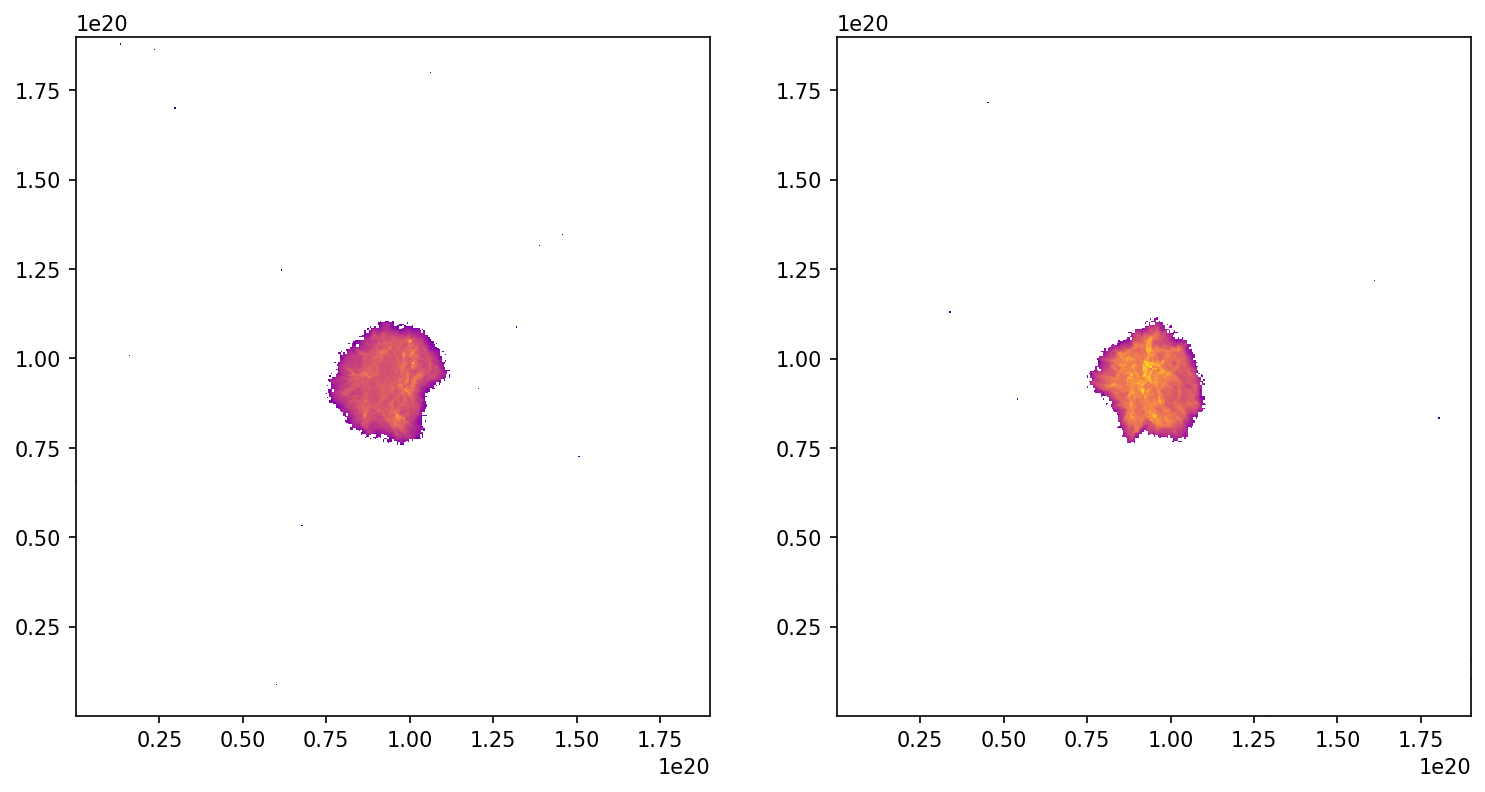

In [10]:
matplotlib.rcParams.update({'figure.dpi': 150})
fig = plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
dNew.image(dNew.x, dNew.y, dNew.rho)
#dNew.tempDensity(formatting=False)
#plt.ylim(0.5,3)
#h = plt.hist(vn, bins=100)

plt.subplot(1,2,2)
dOld.image(dOld.x, dOld.y, dOld.rho)
#dOld.tempDensity(formatting=False)
#h = plt.hist(vo, bins=100)
#plt.ylim(0.5,3)

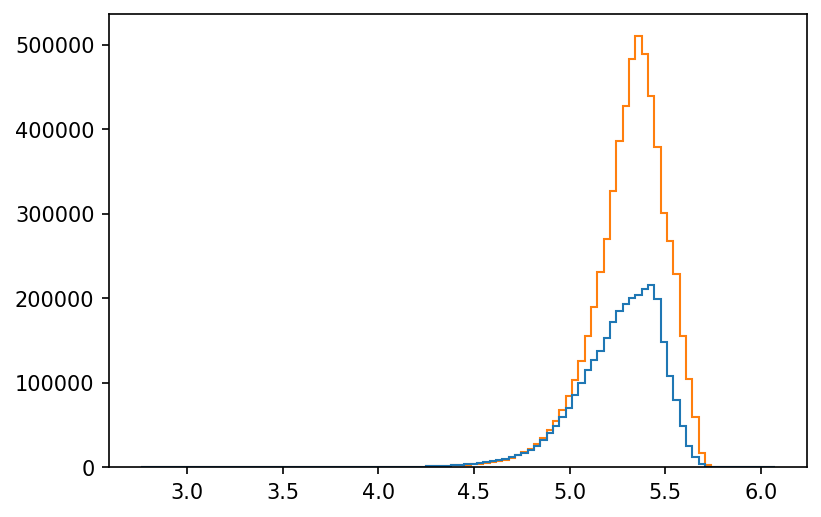

In [11]:
vn = np.sqrt(dNew.vx**2 + dNew.vy**2 + dNew.vz**2)
vo = np.sqrt(dOld.vx**2 + dOld.vy**2 + dOld.vz**2)

plt.figure(figsize=(6,4))
h = plt.hist([np.log10(vn), np.log10(vo)], bins=100, histtype="step")